# De verdeling van edits per editor op Wikipedia

## Notebook made by  

|** one** | **two** | **and a half**|
|:- |:-|:-|
|Bas Verhaar|Sybe Tigchelaar|Iris Bosma|


<img src='http://i.imgur.com/Ao6boSR.jpg' width='400px' align='center' />





## Opzet

* Dataset
* Parser
* Data analyse

## Dataset

* Meerdere Datasets op Wikipedia Dump
* Pagina's met de complete pagina edit geschiedenis
* Onze dataset is 1gb .bz2 file(21gb xml)
* 499 paginas aan edits

verkregen van: https://dumps.wikimedia.org/enwiki/20151201/


## Voorbeeld Dataset

<img src='http://i.imgur.com/mruT7id.png' width='1000px' />

## Focus: Editor graaf

* Hoeveel edits zijn er per editor?
* Hoeveel pagina's zijn geëdit per editor?
* We willen een affiliatie network laten zien van de users (met als edges gemeenschappelijke pagina's)

## Uitleg parser

* Etree parser
* 15 min volledige bestand geparst


In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import pandas as pd
import re
from lxml import etree
from bz2file import BZ2File
from collections import defaultdict
from collections import Counter
import urllib
import os
import sys
import timeit
import networkx as nx
import itertools



print 'All imports done'

#change these two names if you want to try out a new file.
onebigfile = 'enwiki-20151201-pages-meta-history1.xml-p000009358p000010000.bz2'
locationfile = 'https://dumps.wikimedia.org/enwiki/20151201/enwiki-20151201-pages-meta-history1.xml-p000009358p000010000.bz2'

bigfile = '\\'+ onebigfile
f =  os.path.dirname(os.path.abspath("__file__")) + bigfile

print f

All imports done
E:\Bas\Documents\informatiekunde\Data Science\Miniproject\enwiki-20151201-pages-meta-history1.xml-p000009358p000010000.bz2


## Schema
```
<page>
    <title>AccessibleComputing</title>
    <ns>0</ns>
    <id>10</id>
    <redirect title="Computer accessibility" />
    <revision>
      <id>233192</id>
      <timestamp>2001-01-21T02:12:21Z</timestamp>
      <contributor>
        <username>RoseParks</username>
        <id>99</id>
      </contributor>
      <comment>*</comment>
      <model>wikitext</model>
      <format>text/x-wiki</format>
      <text xml:space="preserve">This subject</text>
      <sha1>8kul9tlwjm9oxgvqzbwuegt9b2830vw</sha1>
    </revision>
    <revision>
      <id>862220</id>
      <parentid>233192</parentid>
      <timestamp>2002-02-25T15:43:11Z</timestamp>
      <contributor>
        <username>Conversion script</username>
        <id>0</id>
      </contributor>
      <minor />
      <comment>Automated conversion</comment>
      <model>wikitext</model>
      <format>text/x-wiki</format>
      <text xml:space="preserve">#REDIRECT [[Accessible Computing]]
</text>
      <sha1>i8pwco22fwt12yp12x29wc065ded2bh</sha1>
    </revision>
```

In [2]:
start = timeit.default_timer()

numberEdit=defaultdict(int)
numberPages = defaultdict(set)
pageIDs = []

with BZ2File(f) as xml_file:

    context = etree.iterparse(xml_file,  tag= '{http://www.mediawiki.org/xml/export-0.10/}page')

    c=0
    p=0
    for _, elem in context:
        page_id = int(elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}id')) 
        p+=1
        pageIDs.append(page_id)
        tag = '{http://www.mediawiki.org/xml/export-0.10/}revision/{http://www.mediawiki.org/xml/export-0.10/}contributor'
        contribs=elem.findall(tag)
        tagid = '{http://www.mediawiki.org/xml/export-0.10/}id'
        editorIDs=[cc.findtext(tagid) for cc in contribs if cc.findtext(tagid) is not None]    
        for editor in editorIDs:
            numberEdit[editor] += 1
            numberPages[editor] |= {page_id}

        c+=1
        elem.clear()
        for ancestor in elem.xpath('ancestor-or-self::*'):
            while ancestor.getprevious() is not None:
                del ancestor.getparent()[0]    
        
        if c% 10**2==0:
            print c, p
    del context  
    
print 'File parsed. Total of ', c, ' pages editted and parsed.'
stop = timeit.default_timer()
print '1GB .bz2 file with complete page edit history took:'
print (stop - start) / 60, ' minutes'

100 100
200 200
300 300
400 400
File parsed. Total of  499  pages editted and parsed.
1GB .bz2 file with complete page edit history took:
12.4786047895  minutes


## Wat doen we met de data?
* Eerst naar DataFrame
* Vervolgens wat gegevens checken
* Dan een aantal plots maken
* Tenslotte een netwerk graaf maken

## Eerst naar DataFrame

In [3]:
print 'Dataframe of necassary information'
df = pd.DataFrame(numberEdit.items(), columns=['User ID', 'Number of edits'])

lenNumberPages = {k: len(numberPages[k]) for k in numberPages.keys()}

numberPages = {k:list(numberPages[k]) for k in numberPages.keys()}

df['Pages editted'] = df['User ID'].map(numberPages)
df['Number of pages editted'] = df['User ID'].map(lenNumberPages)
df.head(10)


Dataframe of necassary information


,User ID,Number of edits,Pages editted,Number of pages editted
0,17866318,1,[9534],1
1,240060,1,[9731],1
2,1983992,1,[9995],1
3,89372,3,"[9634, 9979]",2
4,3480985,1,[9587],1
5,741864,4,"[9931, 9902, 9455]",3
6,4043681,1,[9566],1
7,15548685,1,[9508],1
8,2986555,1,[9472],1
9,460061,1,[9611],1


## Vervolgens wat gegevens checken

In [4]:
print 'Total amount of edits:'
print df['Number of edits'].sum()
print 'User ID with most edits:'
print df.loc[df['Number of edits'].argmax()]['User ID']
print 'He made' , df.loc[df['Number of edits'].argmax()]['Number of edits']

print 'Mean and median of number of edits per user: '
print 'Mean: ',df['Number of edits'].mean()
print 'Median: ',df['Number of edits'].median()

print '\nMean and median of number of pages editted per user: '
print 'Mean: ',df['Number of pages editted'].mean()
print 'Median: ',df['Number of pages editted'].median()

Total amount of edits:
321279
User ID with most edits:
13286072
He made 4289
Mean and median of number of edits per user: 
Mean:  6.56931664826
Median:  1.0

Mean and median of number of pages editted per user: 
Mean:  2.41874207664
Median:  1.0


<img src='http://i.imgur.com/ElHwztc.png' />

## Dan een aantal plots

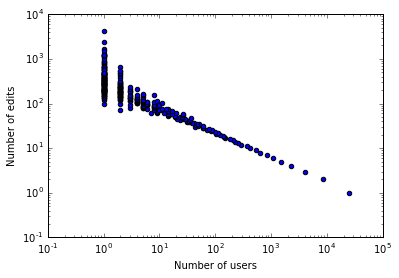

In [5]:
plot1 = df.groupby('Number of edits').count()['Number of pages editted'].to_dict()
x = plot1.values()
y = plot1.keys()
fig = plt.figure()
ax = plt.gca()
ax.scatter(x,y)
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel('Number of edits')
plt.xlabel('Number of users')


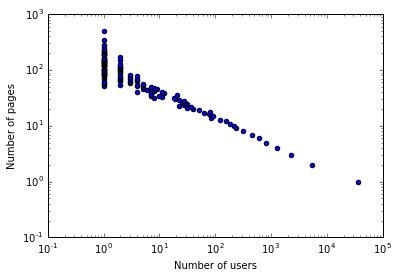

In [6]:
plot2 = df.groupby('Number of pages editted').count()['Number of edits'].to_dict()
x = plot2.values()
y = plot2.keys()
fig = plt.figure()
ax = plt.gca()
ax.scatter(x,y)
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel('Number of pages')
plt.xlabel('Number of users')


## Tenslotte een graaf (work in progress)

In [ ]:
listOfUsers = df['User ID'].tolist()
K = nx.Graph()
K.add_nodes_from(listOfUsers)
print pageIDs
c = 0
for page in pageIDs:
    users = [k for k in numberPages.keys() if page in numberPages[k]]
    for u, v in itertools.combinations(users, 2):
        c += 1
        K.add_edge(u,v)

print c

<img src='http://i.imgur.com/47EDI7b.png' />